## Proyecto Final

### Integrantes
### Oziel Imanol Lemus Montelongo
### Daniel Isaí Saldaña Rocha
### Guillermo Gonzalo Veyro Ramos

## Modelo Estrella

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./vgsales.csv')

genre_sales = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)

platform_sales = data.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False)

publisher_sales = data.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False)

top_genres = genre_sales.head(5)
top_platforms = platform_sales.head(5)
top_publishers = publisher_sales.head(5)

print("Top 5 Géneros por Ventas Globales:")
print(top_genres)
print("\nTop 5 Plataformas por Ventas Globales:")
print(top_platforms)
print("\nTop 5 Publicadoras por Ventas Globales:")
print(top_publishers)


Top 5 Géneros por Ventas Globales:
Genre
Action          563.00
Shooter         487.12
Platform        433.80
Role-Playing    398.94
Sports          395.72
Name: Global_Sales, dtype: float64

Top 5 Plataformas por Ventas Globales:
Platform
Wii     444.46
X360    391.59
PS2     390.45
PS3     333.88
DS      312.75
Name: Global_Sales, dtype: float64

Top 5 Publicadoras por Ventas Globales:
Publisher
Nintendo                       1313.27
Activision                      304.95
Electronic Arts                 291.30
Sony Computer Entertainment     275.49
Take-Two Interactive            191.24
Name: Global_Sales, dtype: float64


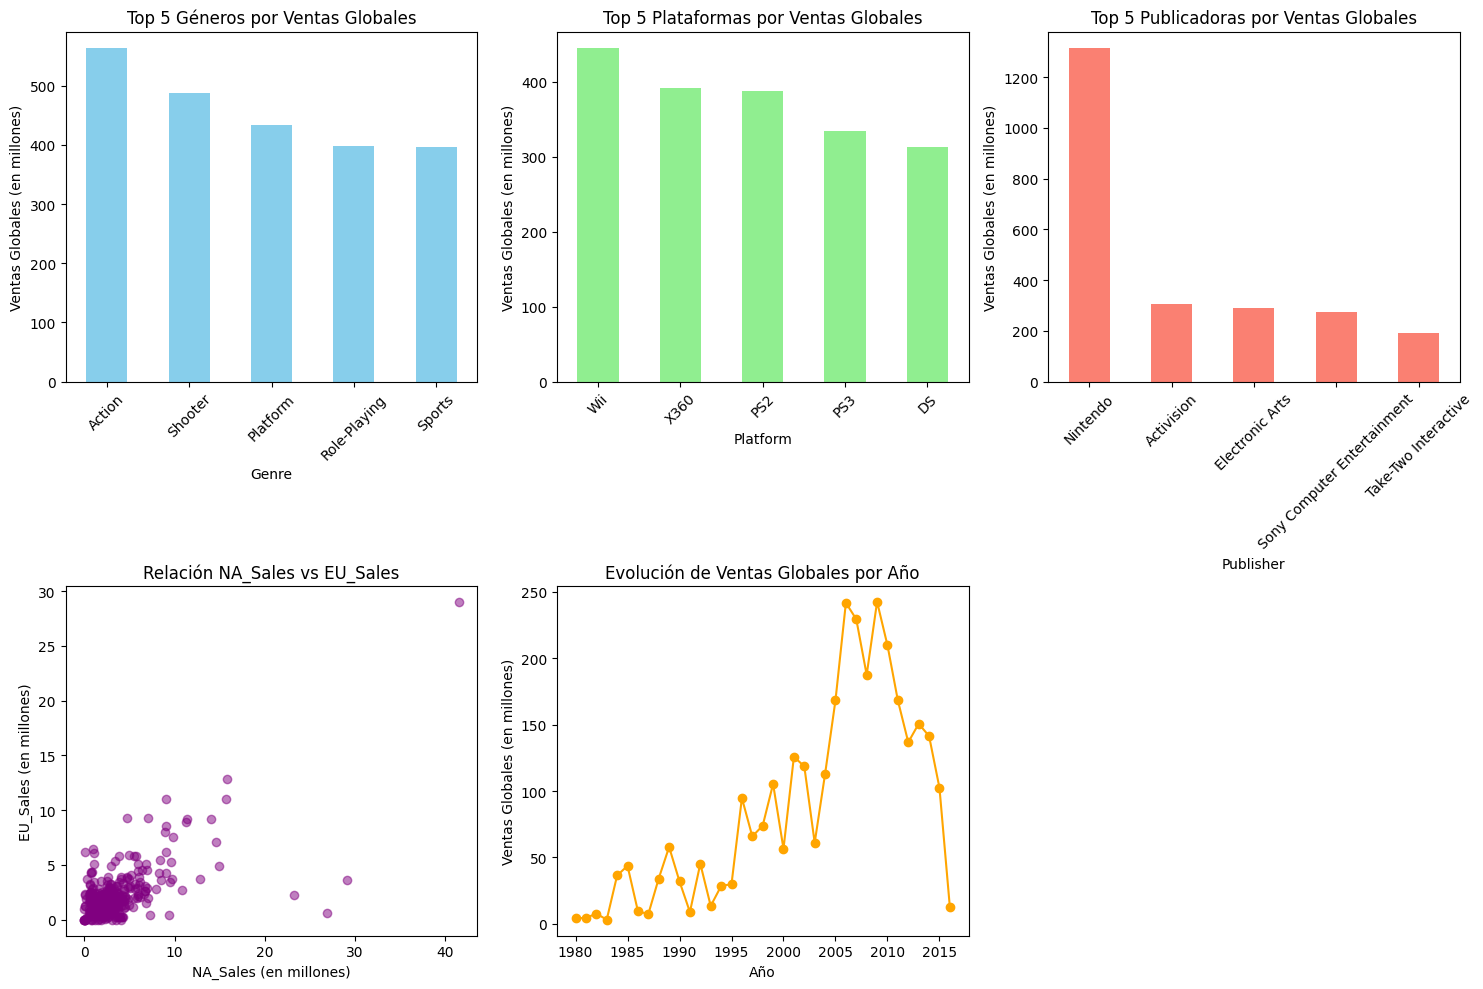

In [2]:
# Limpieza de datos
# Eliminar duplicados
data = data.drop_duplicates()

# Manejo de valores faltantes
data['Year'] = data['Year'].fillna(data['Year'].median()) 
data = data.dropna(subset=['Publisher'])

# Conversión de tipos
data['Year'] = data['Year'].astype(int)

# Gráficos exploratorios
plt.figure(figsize=(15, 10))

# Gráfico 1: Top 5 Géneros por Ventas Globales
genre_sales = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 1)
genre_sales.plot(kind='bar', color='skyblue')
plt.title('Top 5 Géneros por Ventas Globales')
plt.ylabel('Ventas Globales (en millones)')
plt.xticks(rotation=45)

# Gráfico 2: Top 5 Plataformas por Ventas Globales
platform_sales = data.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 2)
platform_sales.plot(kind='bar', color='lightgreen')
plt.title('Top 5 Plataformas por Ventas Globales')
plt.ylabel('Ventas Globales (en millones)')
plt.xticks(rotation=45)

# Gráfico 3: Top 5 Publicadoras por Ventas Globales
publisher_sales = data.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 3)
publisher_sales.plot(kind='bar', color='salmon')
plt.title('Top 5 Publicadoras por Ventas Globales')
plt.ylabel('Ventas Globales (en millones)')
plt.xticks(rotation=45)

# Gráfico 4: Relación entre NA_Sales y EU_Sales
plt.subplot(2, 3, 4)
plt.scatter(data['NA_Sales'], data['EU_Sales'], alpha=0.5, color='purple')
plt.title('Relación NA_Sales vs EU_Sales')
plt.xlabel('NA_Sales (en millones)')
plt.ylabel('EU_Sales (en millones)')

# Gráfico 5: Evolución de Ventas Globales por Año
sales_by_year = data.groupby('Year')['Global_Sales'].sum()
plt.subplot(2, 3, 5)
sales_by_year.plot(kind='line', color='orange', marker='o')
plt.title('Evolución de Ventas Globales por Año')
plt.xlabel('Año')
plt.ylabel('Ventas Globales (en millones)')

plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import psycopg2


# Manejo de valores faltantes
data['Year'] = data['Year'].fillna(data['Year'].median())  
data = data.dropna(subset=['Publisher'])

# Conversión de tipos
data['Year'] = data['Year'].astype(int)

cuantitativas = data.select_dtypes(include=['int64', 'float64'])
cualitativas = data.select_dtypes(include=['object'])

# Conexión a PostgreSQL
try:
    conn = psycopg2.connect(
        user="postgres",
        password="root",
        host="localhost",
        port="5432",
        database="DbVideogamesSales"
    )
    print("Conexión exitosa a la base de datos")
except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")
    exit()

# Crear cursor
cur = conn.cursor()

def crear_tabla(df, nombre_tabla, cur, conn):
    """Crea una tabla en la base de datos PostgreSQL a partir de un DataFrame."""
    dtype_mapping = {
        'object': 'TEXT',
        'int64': 'INT',
        'float64': 'FLOAT',
        'bool': 'BOOLEAN'
    }

    columns = []
    for col, dtype in zip(df.columns, df.dtypes):
        pg_type = dtype_mapping.get(str(dtype), 'TEXT')
        columns.append(f"{col} {pg_type}")

    columns_sql = ", ".join(columns)
    SQLQuery = f"CREATE TABLE IF NOT EXISTS {nombre_tabla} ({columns_sql});"
    try:
        cur.execute(SQLQuery)
        conn.commit()
        print(f"Tabla '{nombre_tabla}' creada correctamente.")
    except Exception as e:
        print(f"Error al crear la tabla '{nombre_tabla}': {e}")

def insertar_datos(df, nombre_tabla, cur, conn):
    """Inserta datos en una tabla de PostgreSQL a partir de un DataFrame."""
    df = df.where(pd.notnull(df), None)  # Reemplazar NaN por None
    columns = df.columns.tolist()
    values_template = ", ".join(["%s"] * len(columns))
    insert_query = f"INSERT INTO {nombre_tabla} ({', '.join(columns)}) VALUES ({values_template}) ON CONFLICT DO NOTHING;"

    values = [tuple(row) for row in df.to_numpy()]

    try:
        cur.executemany(insert_query, values)
        conn.commit()
        print(f"Datos insertados correctamente en la tabla '{nombre_tabla}'.")
    except Exception as e:
        conn.rollback()
        print(f"Error al insertar datos en la tabla '{nombre_tabla}': {e}")

# Crear tablas para datos cuantitativos y cualitativos
crear_tabla(cuantitativas, 'cuantitativas', cur, conn)
crear_tabla(cualitativas, 'cualitativas', cur, conn)

# Insertar datos en las tablas
insertar_datos(cuantitativas, 'cuantitativas', cur, conn)
insertar_datos(cualitativas, 'cualitativas', cur, conn)

# Conexión a la base de datos del data warehouse
dwh_conn = None
try:
    dwh_conn = psycopg2.connect(
        user="postgres",
        password="root",
        host="localhost",
        port="5432",
        database="dwhissc712"
    )
    print("Conexión exitosa al data warehouse")
except Exception as e:
    print(f"Error al conectar al data warehouse: {e}")
    exit()

dwh_cur = dwh_conn.cursor()

# Crear dimensiones y tabla de hechos en el data warehouse
# Dimensiones
platform_dimension = data[['Platform']].drop_duplicates().reset_index(drop=True)
platform_dimension['PlatformID'] = platform_dimension.index + 1
crear_tabla(platform_dimension, 'dim_platform', dwh_cur, dwh_conn)
insertar_datos(platform_dimension, 'dim_platform', dwh_cur, dwh_conn)

genre_dimension = data[['Genre']].drop_duplicates().reset_index(drop=True)
genre_dimension['GenreID'] = genre_dimension.index + 1
crear_tabla(genre_dimension, 'dim_genre', dwh_cur, dwh_conn)
insertar_datos(genre_dimension, 'dim_genre', dwh_cur, dwh_conn)

# Tabla de hechos
fact_table = data.merge(platform_dimension, on='Platform').merge(genre_dimension, on='Genre')
fact_table = fact_table[['PlatformID', 'GenreID', 'Year', 'Global_Sales']]
crear_tabla(fact_table, 'fact_sales', dwh_cur, dwh_conn)
insertar_datos(fact_table, 'fact_sales', dwh_cur, dwh_conn)

# Cerrar conexiones
cur.close()
conn.close()
dwh_cur.close()
dwh_conn.close()


Conexión exitosa a la base de datos
Tabla 'cuantitativas' creada correctamente.
Tabla 'cualitativas' creada correctamente.
Datos insertados correctamente en la tabla 'cuantitativas'.
Datos insertados correctamente en la tabla 'cualitativas'.
Conexión exitosa al data warehouse
Tabla 'dim_platform' creada correctamente.
Datos insertados correctamente en la tabla 'dim_platform'.
Tabla 'dim_genre' creada correctamente.
Datos insertados correctamente en la tabla 'dim_genre'.
Tabla 'fact_sales' creada correctamente.
Datos insertados correctamente en la tabla 'fact_sales'.


# 2do Parcial
## Analisis de clustering con k-means

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

In [ ]:
df_kmeans = data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
df_multiLinear = df_kmeans ##Se utiliza para la sección de 3er parcial

df_kmeans.head()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,41.49,29.02,3.77,8.46,82.74
1,29.08,3.58,6.81,0.77,40.24
2,15.85,12.88,3.79,3.31,35.82
3,15.75,11.01,3.28,2.96,33.00
4,11.27,8.89,10.22,1.00,31.37


In [7]:
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(df_kmeans)

In [8]:
pca = PCA(n_components=5)
componentes_pca = pca.fit_transform(datos_escalados)

In [9]:
variacion_explicada = pca.explained_variance_ratio_

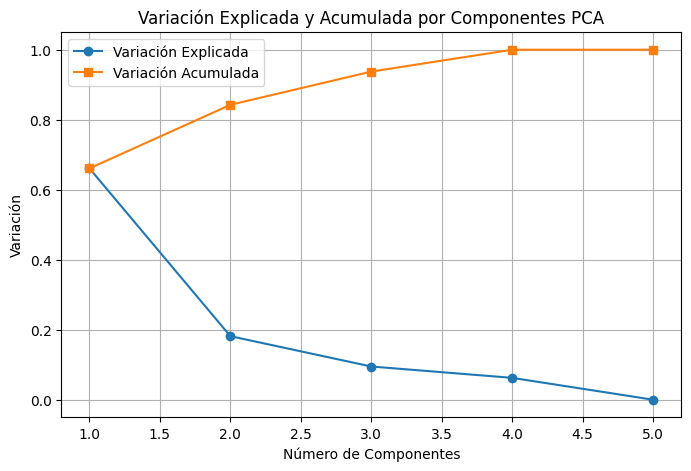

In [10]:
variacion_acumulada = np.cumsum(variacion_explicada)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variacion_explicada) + 1), variacion_explicada, marker='o', label='Variación Explicada')
plt.plot(range(1, len(variacion_acumulada) + 1), variacion_acumulada, marker='s', label='Variación Acumulada')

plt.xlabel('Número de Componentes')
plt.ylabel('Variación')
plt.title('Variación Explicada y Acumulada por Componentes PCA')
plt.legend()
plt.grid(True)

plt.show()

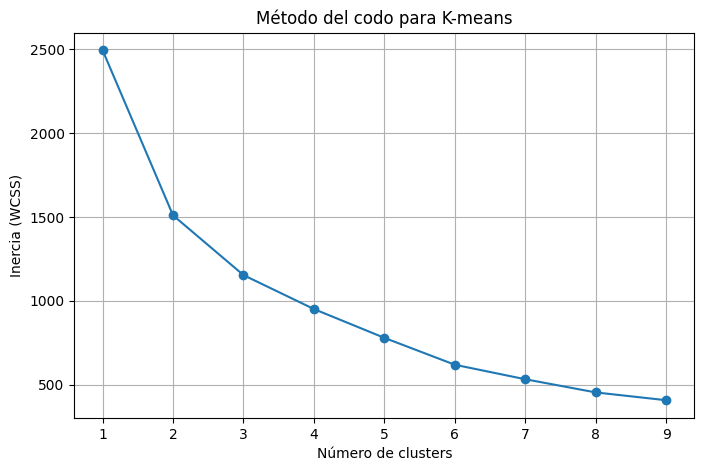

In [11]:
wcss = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(componentes_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Método del codo para K-means')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia (WCSS)')
plt.grid(True)
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_25636\3573540378.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans['Cluster'] = cluster_kmeans


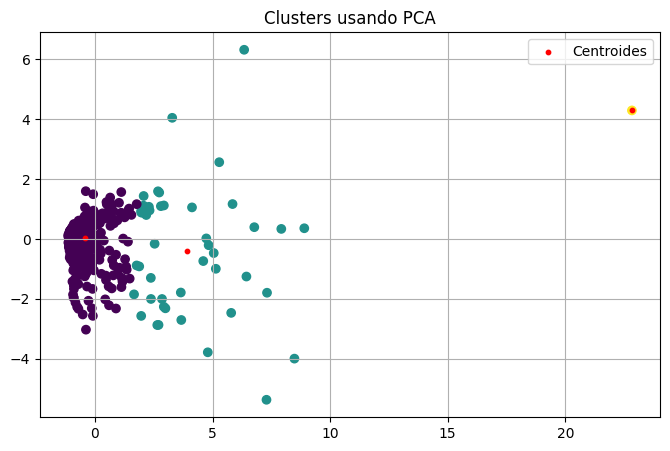

In [12]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
cluster_kmeans = kmeans.fit_predict(componentes_pca)

df_kmeans['Cluster'] = cluster_kmeans

plt.figure(figsize=(8, 5))
plt.scatter(componentes_pca[:, 0], componentes_pca[:, 1], c=df_kmeans['Cluster'], cmap='viridis', marker='o')

centroides = kmeans.cluster_centers_
plt.scatter(centroides[:, 0], centroides[:, 1], s=10, c='red', marker='o', label='Centroides')

plt.title('Clusters usando PCA')
plt.legend()
plt.grid(True)
plt.show()

## 3er parcial

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split ##Fase de pruebas de entrenamiento
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score #COEFICIENTE DE DETERMINACION
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import Ridge, Lasso, ElasticNet
## EVALUAR METRICAS DE RENDIMIENTO
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [70]:
df_multiLinear

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Cluster
0,41.49,29.02,3.77,8.46,82.74,2
1,29.08,3.58,6.81,0.77,40.24,1
2,15.85,12.88,3.79,3.31,35.82,1
3,15.75,11.01,3.28,2.96,33.00,1
4,11.27,8.89,10.22,1.00,31.37,1
...,...,...,...,...,...,...
495,1.54,1.14,0.00,0.22,2.90,0
496,1.75,0.86,0.00,0.28,2.90,0
497,0.08,1.24,1.13,0.45,2.90,0
498,0.71,1.51,0.06,0.61,2.89,0


#### Single Linear regression

In [71]:
vIndSingle = df_multiLinear['NA_Sales'].values.reshape(-1, 1) 
# -1 ubica el numero de elementos y lo convierte al numero de filas
# el 1 es solo pora indicar que solo se va a usar una columna

vDepSingle = df_multiLinear['Global_Sales'].values

In [ ]:
# Creación de variables independientes y dependientes de pruebas y entrenamiento
vInd_entrenamientoSingle, vInd_pruebasSingle, vDep_entrenamientoSingle, vDep_pruebasSingle = train_test_split(vIndSingle, vDepSingle, test_size = 0.2, random_state = 42)

In [ ]:
# Asignacion del modelo de regrecion lineal para el modelo simple
modeloSingle = LinearRegression()
modeloSingle.fit(vInd_entrenamientoSingle, vDep_entrenamientoSingle)

LinearRegression()

In [74]:
#Pendiente e Interseccion

pendienteSingle = modeloSingle.coef_[0]
interseccionSingle = modeloSingle.intercept_

print(f"Pendiente (m): {pendienteSingle}")
print(f"intersección (m): {interseccionSingle}")

Pendiente (m): 1.6186902354790034
intersección (m): 1.476765979695931


In [75]:
# Calcular las predicciones
prediccion_entrenamientoSingle = modeloSingle.predict(vInd_entrenamientoSingle)

prediccion_pruebaSingle = modeloSingle.predict(vInd_pruebasSingle)

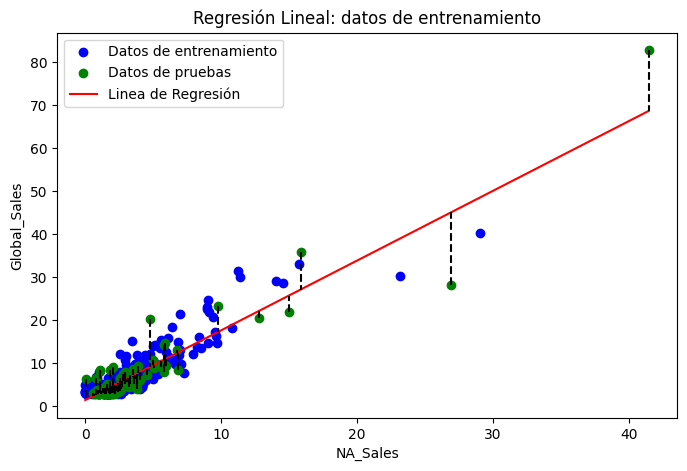

R2 en datos de pruebas: 0.8825319231938941


In [ ]:
plt.figure(figsize=(8,5))
# VALORES DE ENTRENAMIENTO
plt.scatter(vInd_entrenamientoSingle, vDep_entrenamientoSingle, label='Datos de entrenamiento', color='blue')
plt.scatter(vInd_pruebasSingle, vDep_pruebasSingle, label='Datos de pruebas', color='green')

# GRAFICAR LINEA DE REGRESION LINEAL SIMPLE
Linea = np.linspace(min(vIndSingle), max(vIndSingle)).reshape(-1,1)
Linea_prediccion = modeloSingle.predict(Linea)
plt.plot(Linea, Linea_prediccion, label='Linea de Regresión', color='Red')

#Marcar error o residuo
for i in range(len(vInd_pruebasSingle)):
    plt.plot([vInd_pruebasSingle[i], vInd_pruebasSingle[i]], [vDep_pruebasSingle[i], prediccion_pruebaSingle[i]], color='black', linestyle='--')

plt.plot()

plt.xlabel('NA_Sales')
plt.ylabel('Global_Sales')
plt.title('Regresión Lineal: datos de entrenamiento')
plt.legend()
plt.show()

# R2 - COEFICIENTE DE DETERMINACIÓN
r2_pruebas =  r2_score(vDep_pruebasSingle, prediccion_pruebaSingle)

print(f"R2 en datos de pruebas: {r2_pruebas}")

#### Multiple Linear regression

In [ ]:
#Asignación de variables al modelo multiple
vIndMultiple = df_multiLinear[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]

vDepMultiple  = df_multiLinear['Global_Sales'].values

In [ ]:
# Variables contante y vif de datos
vConstante = add_constant(vIndMultiple)
vif_datos = pd.DataFrame()

vif_datos['Nombre Variables'] = vConstante.columns

vif_datos['VIF'] = [variance_inflation_factor(vConstante.values, i) for i in range(len(vConstante.columns))]

In [52]:
vif_datos

,Nombre Variables,VIF
0,const,2.101315
1,NA_Sales,1.875242
2,EU_Sales,2.232828
3,JP_Sales,1.197166
4,Other_Sales,1.628721


In [ ]:
#Creación de variables independientes y dependientes de pruebas y entrenamiento
vInd_entrenamiento, vInd_pruebas, vDep_entrenamiento, vDep_pruebas = train_test_split(vIndMultiple, vDepMultiple, test_size = 0.2, random_state = 42)

In [54]:
scalado = StandardScaler()
vIndependienteEntrenamientoScalado = scalado.fit_transform(vInd_entrenamiento)
vIndependientePruebasScalado = scalado.transform(vInd_pruebas)

In [ ]:
vIndependienteEntrenamientoScalado #Variable independiente entrenada escalada

array([[ 0.68009884,  1.2145712 , -0.29919247,  1.28442277],
       [-0.33606669,  0.07983488, -0.5634488 ,  0.14394259],
       [-0.53065157,  0.02341153, -0.54142744,  0.23071826],
       ...,
       [-1.01711379, -1.1426711 , -0.1523834 ,  2.90836736],
       [-0.34327353, -1.04236291,  0.10453247, -0.61224535],
       [ 0.22967086,  0.75691511, -0.62217242,  0.18113216]])

In [ ]:
vIndependientePruebasScalado #Variable independiente de prueba escalada

array([[-2.92825601e-01, -7.41438365e-01, -5.34086983e-01,
        -4.51090543e-01],
       [-3.10842720e-01,  3.11797553e-01,  2.57826531e+00,
        -2.15556594e-01],
       [-1.63102342e-01, -5.72168307e-01,  2.21979730e-01,
        -5.62659256e-01],
       [ 1.64809227e-01, -6.47399444e-01,  1.77937009e-01,
        -6.49434921e-01],
       [ 1.14361294e-01, -5.65899045e-01, -6.14831971e-01,
        -2.03160070e-01],
       [-5.01824184e-01, -5.09475692e-01, -5.92810611e-01,
         9.43564969e-02],
       [ 3.50859690e-02, -7.10092058e-01,  7.06449662e-01,
        -5.87452303e-01],
       [ 7.62977585e-01,  1.17068637e+00, -3.43235191e-01,
         1.29681929e+00],
       [-4.98220760e-01, -1.52127792e-01, -5.48767890e-01,
         3.23738788e-02],
       [ 8.66888950e+00, -7.47707626e-01, -4.16639726e-01,
        -1.41177452e-01],
       [ 1.43188684e-01,  6.31529885e-01, -5.63448797e-01,
         5.40631348e-01],
       [-2.74808482e-01, -4.46783078e-01, -9.36597716e-02,
      

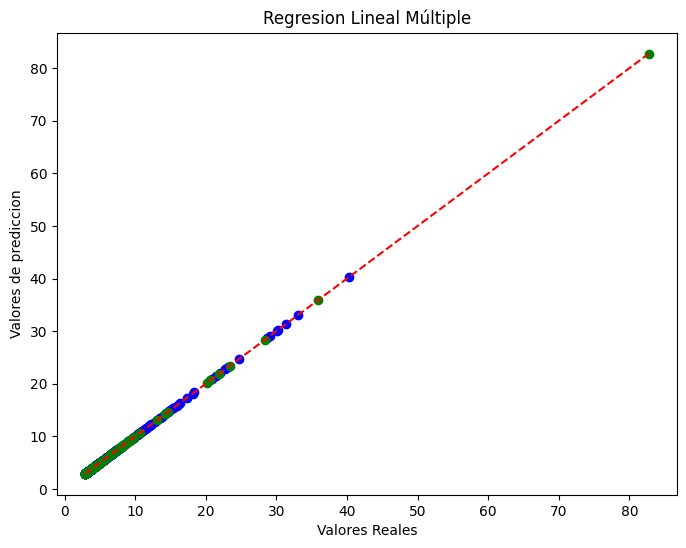

0.999999579509266


In [ ]:
modelo = LinearRegression() ## APLICAR MODELO DE REGRESION LINEAL
modelo.fit(vIndependienteEntrenamientoScalado, vDep_entrenamiento)

predicciones_rlm_entrenamiento = modelo.predict(vIndependienteEntrenamientoScalado) #Prediccion de Regrecion lineal de entrenamiento
predicciones_rlm_prueba = modelo.predict(vIndependientePruebasScalado) #Prediccion de Regrecion lineal de prueba

#Configuracion de las variable en el grafico
plt.figure(figsize=(8,6))
plt.scatter(vDep_entrenamiento, predicciones_rlm_entrenamiento, color='blue')
plt.scatter(vDep_pruebas, predicciones_rlm_prueba, color='green')
#LINEA DE IDENTIDAD
plt.plot(
    [vDepMultiple.min(), vDepMultiple.max()],
    [vDepMultiple.min(), vDepMultiple.max()], 'r--'
)

#Titulos y creacion de grafica
plt.xlabel('Valores Reales')
plt.ylabel('Valores de prediccion')
plt.title('Regresion Lineal Múltiple')
plt.show()

#Evaluación de r2
r2_rlm = r2_score(vDep_pruebas, modelo.predict(vIndependientePruebasScalado))
print(r2_rlm)

In [ ]:
#Creación de pendiente y intersección
pendiente = modelo.coef_
interseccion = modelo.intercept_

print(f"Pendiente (m): {pendiente}")
print(f"Pendiente (m): {interseccion}")

Pendiente (m): [2.77513437 1.59505134 1.36252659 0.80693744]
Pendiente (m): 6.126666666666667


In [ ]:
#Mean square error & mean absolute error
mse_rlm = mean_squared_error(vDep_pruebas, predicciones_rlm_prueba)
rsem_rlm = np.sqrt(mse_rlm)
mae_rlm = mean_absolute_error(vDep_pruebas, predicciones_rlm_prueba)
print("mean_squared_error: ", mse_rlm)
print("mean_absolute_error: ", mae_rlm)

mean_squared_error:  3.686401552756112e-05
mean_absolute_error:  0.003797156729107556


#### Ridge

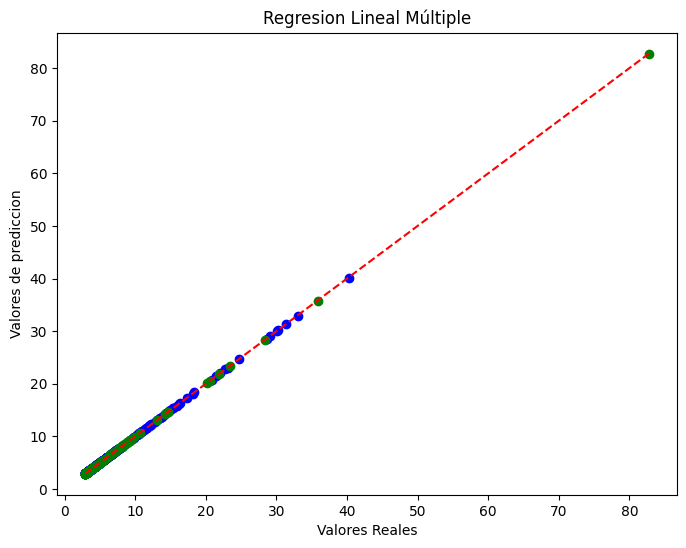

0.999997931651217


In [ ]:
modelo_ridge = Ridge(alpha=1.0) #Espesificación del modelo con el alpha 1.0
modelo_ridge.fit(vIndependienteEntrenamientoScalado, vDep_entrenamiento)

predicciones_ridge_entrenamiento = modelo_ridge.predict(vIndependienteEntrenamientoScalado) #Prediccion de Ridge de entrenamiento
predicciones_ridge_prueba = modelo_ridge.predict(vIndependientePruebasScalado) #Prediccion de Ridge de pruebas

#Configuracion de las variable en el grafico
plt.figure(figsize=(8,6))
plt.scatter(vDep_entrenamiento, predicciones_ridge_entrenamiento, color='blue')
plt.scatter(vDep_pruebas, predicciones_ridge_prueba, color='green')
#LINEA DE IDENTIDAD
plt.plot(
    [vDepMultiple.min(), vDepMultiple.max()],
    [vDepMultiple.min(), vDepMultiple.max()], 'r--'
)

#Titulos y creacion de grafica
plt.xlabel('Valores Reales')
plt.ylabel('Valores de prediccion')
plt.title('Regresion Lineal Múltiple')
plt.show()

#Evaluación de r2
r2_rlm = r2_score(vDep_pruebas, modelo_ridge.predict(vIndependientePruebasScalado))
print(r2_rlm)

In [ ]:
#Creación de pendiente y intersección
pendiente_ridge = modelo_ridge.coef_
interseccion_ridge = modelo_ridge.intercept_

print(f"Pendiente (m): {pendiente_ridge}")
print(f"Interseccion (m): {interseccion_ridge}")

Pendiente (m): [2.76845171 1.59482639 1.36184731 0.80735407]
Interseccion (m): 6.126666666666667


In [ ]:
#Mean square error & mean absolute error
mse_ridge = mean_squared_error(vDep_pruebas, predicciones_ridge_prueba)
rsem_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(vDep_pruebas, predicciones_ridge_prueba)
print("mean_squared_error: ", mse_ridge)
print("Raiz: ", rsem_ridge)
print("mean_absolute_error: ", mae_ridge)

mean_squared_error:  0.00018133013521320584
Raiz:  0.013465887836054697
mean_absolute_error:  0.007601600019651724


#### Lasso

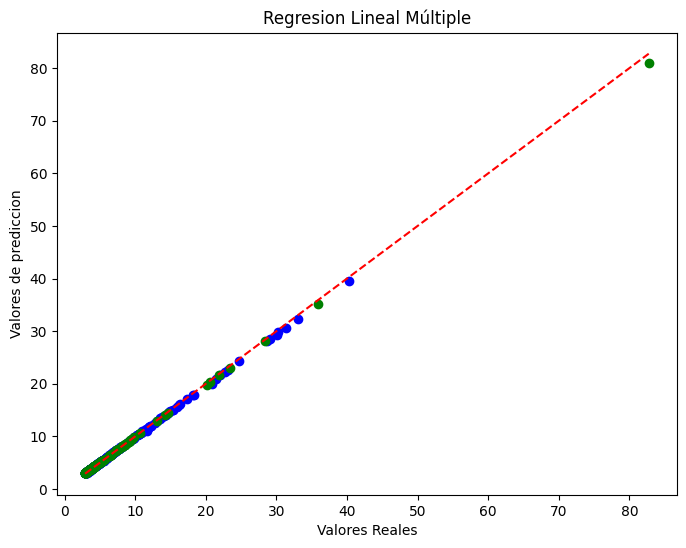

0.9994537114921487


In [ ]:
modelo_lasso = Lasso(alpha=0.1) #Espesificación del modelo de 0.1 en decimal
modelo_lasso.fit(vIndependienteEntrenamientoScalado, vDep_entrenamiento)

predicciones_lasso_entrenamiento = modelo_lasso.predict(vIndependienteEntrenamientoScalado) #Prediccion de Lasso de entrenamiento
predicciones_lasso_prueba = modelo_lasso.predict(vIndependientePruebasScalado) #Prediccion de Lasso de prueba

#Configuracion de las variable en el grafico
plt.figure(figsize=(8,6))
plt.scatter(vDep_entrenamiento, predicciones_lasso_entrenamiento, color='blue')
plt.scatter(vDep_pruebas, predicciones_lasso_prueba, color='green')
#LINEA DE IDENTIDAD
plt.plot(
    [vDepMultiple.min(), vDepMultiple.max()],
    [vDepMultiple.min(), vDepMultiple.max()], 'r--'
)

#Titulos y creacion de grafica
plt.xlabel('Valores Reales')
plt.ylabel('Valores de prediccion')
plt.title('Regresion Lineal Múltiple')
plt.show()

#Evaluación de r2
r2_rlm = r2_score(vDep_pruebas, modelo_lasso.predict(vIndependientePruebasScalado))
print(r2_rlm)

In [ ]:
#Creación de pendiente y intersección
pendiente_lasso = modelo_lasso.coef_
interseccion_lasso = modelo_lasso.intercept_

print(f"Pendiente (m): {pendiente_lasso}")
print(f"Intersección (m): {interseccion_lasso}")

Pendiente (m): [2.74525478 1.56798289 1.28809853 0.73400564]
Intersección (m): 6.126666666666667


In [ ]:
#Mean square error & mean absolute error
mse_lasso = mean_squared_error(vDep_pruebas, predicciones_lasso_prueba)
rsem_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(vDep_pruebas, predicciones_lasso_prueba)
print("mean_squared_error: ", mse_lasso)
print("Raiz: ", rsem_lasso)
print("mean_absolute_error: ", mae_lasso)

mean_squared_error:  0.04789258456133078
Raiz:  0.21884374462463116
mean_absolute_error:  0.10649977256914077


#### ElasticNet

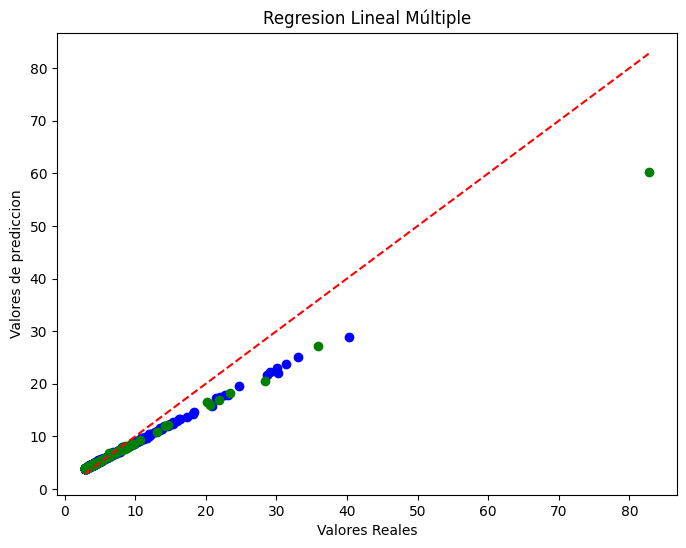

0.9095771849674212


In [ ]:
modelo_elastic = ElasticNet(alpha=1.0,l1_ratio=0.5) #Espesificación del modelo de 50 y 50 entre ridge y lasso
modelo_elastic.fit(vIndependienteEntrenamientoScalado, vDep_entrenamiento)

predicciones_elasticNet_entrenamiento = modelo_elastic.predict(vIndependienteEntrenamientoScalado) #Prediccion de elasticNet de entrenamiento
predicciones_elasticNet_prueba = modelo_elastic.predict(vIndependientePruebasScalado) #Prediccion de elasticNet de pruebas

#Configuracion de las variable en el grafico
plt.figure(figsize=(8,6))
plt.scatter(vDep_entrenamiento, predicciones_elasticNet_entrenamiento, color='blue')
plt.scatter(vDep_pruebas, predicciones_elasticNet_prueba, color='green')
#LINEA DE IDENTIDAD
plt.plot(
    [vDepMultiple.min(), vDepMultiple.max()],
    [vDepMultiple.min(), vDepMultiple.max()], 'r--'
)

#Titulos y creacion de grafica
plt.xlabel('Valores Reales')
plt.ylabel('Valores de prediccion')
plt.title('Regresion Lineal Múltiple')
plt.show()

#Evaluación de r2
r2_rlm = r2_score(vDep_pruebas, modelo_elastic.predict(vIndependientePruebasScalado))
print(r2_rlm)

In [ ]:
#Creación de pendiente y intersección
pendiente_elastic = modelo_elastic.coef_
interseccion_elastic = modelo_elastic.intercept_

print(f"Pendiente (m): {pendiente_elastic}")
print(f"Interseccion (m): {interseccion_elastic}")

Pendiente (m): [1.82273427 1.25999909 0.9145072  0.54079301]
Pendiente (m): 6.126666666666667


In [ ]:
#Mean square error & mean absolute error
mse_elastic = mean_squared_error(vDep_pruebas, predicciones_elasticNet_prueba)
rsem_elastic = np.sqrt(mse_elastic)
mae_elastic = mean_absolute_error(vDep_pruebas, predicciones_elasticNet_prueba)
print("mean_squared_error: ", mse_elastic)
print("Raiz: ", rsem_elastic)
print("mean_absolute_error: ", mae_elastic)

mean_squared_error:  7.927280645632433
Raiz:  2.8155426911400996
mean_absolute_error:  1.2370479560023677


#### Conclusión 3er parcial
Agregando de que si utilizamos un modelo simple de regresión es más eficaz cuando tenemos menos datos para poder hacer nuestras predicciones. Puede funcionar, pero si queremos hacer la evaluación de cada variable de ventas de videojuegos. Pero a la vez no puede funcionar si queremos contemplar varios datos porque tendríamos que hacerlo uno por uno.

Pero si se diera un caso como en el proyecto donde se utilizan varios datos para ser más preciso. En este caso es más eficaz para el caso de ventas por países ya que contemplamos varios países para nuestra variable dependiente de ventas globales.

Y gracias al análisis de datos podemos decir que la mejor solución para la multicoleanidad es Ridge, ya que obtenemos una multicolinealidad que respeta propuesta por la original de la regresión lineal múltiple. Además de que necesitamos todas las variables seleccionadas para poder sacar nuestra variable dependiente que son las ventas globales. En este caso solo necesitamos bajar sus coeficientes para poder tener más precisión con nuestros datos.

Además, hay que tomar en cuenta las variables de error que en Ridge son las más bajas compitiendo con las del modelo de lasso, teniendo un mejor ajuste con nuestras predicciones del modelo ridge, dándonos por consecuente predicciones más pequeñas en promedio.

Siendo la más desequilibrada la de ElasticNet.
